In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
train_data.drop(['url_legal', 'license', 'standard_error'], axis=1, inplace=True)
train_data.head(3)

,id,excerpt,target
0,c12129c31,When the young people returned to the ballroom...,-0.340259
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118


In [3]:
test_data = pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)
test_data.head(3)

,id,excerpt
0,c0f722661,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,It was a bright and cheerful scene that greete...


In [4]:
# define X, y and test
X_train = train_data.excerpt
Y_train = train_data.target
final_test = test_data.excerpt

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train) #y_train
y_val = np.array(y_val) #y_test
final_test = np.array(final_test)
X_full = np.array(X_train)
Y_full = np.array(Y_train) #y_full

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english',max_features=100,strip_accents='unicode')
x_train_vector = vectorizer.fit_transform (x_train).toarray() #train_vector
x_val_vector = vectorizer.fit_transform (x_val).toarray() #test_vectors
x_full = vectorizer.fit_transform (X_full).toarray() #vectors_full
final_test_vector = vectorizer.transform (final_test).toarray() #real_test_vectors
print(x_train_vector.shape, y_train.shape)
print(x_val_vector.shape, y_val.shape)
print(final_test_vector.shape)

(2267, 100) (2267,)
(567, 100) (567,)
(7, 100)


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [8]:
def create_model():
    
    model = keras.Sequential([
        layers.Dense(units=512, kernel_initializer='normal', activation='relu', input_shape=[100]),
        layers.Dense(units=256, kernel_initializer='normal', activation='relu'),
        layers.Dense(units=128, kernel_initializer='normal', activation='relu'),
        layers.Dropout(0.25),
        # the linear output layer 
        layers.Dense(units=1, kernel_initializer='normal', activation='linear'),
    ])
    
    model.compile(optimizer = 'adam', loss='mean_squared_error')
    
    return model

In [9]:
# Create a KerasClassifier with best parameters
model_KR = KerasRegressor(build_fn = create_model, batch_size = 16, epochs = 50)

# Calculate the accuracy score for each fold
kfolds = cross_val_score(model_KR, x_full, Y_full, cv = 10)

#get the accuracy
print(kfolds.mean())
print('The mean accuracy:', kfolds.mean())

Epoch 1/50
160/160 [==============================] - 1s 2ms/step - loss: 1.1596
Epoch 2/50
160/160 [==============================] - 0s 2ms/step - loss: 0.7820
Epoch 3/50
160/160 [==============================] - 0s 2ms/step - loss: 0.6804
Epoch 4/50
160/160 [==============================] - 0s 2ms/step - loss: 0.5063
Epoch 5/50
160/160 [==============================] - 0s 2ms/step - loss: 0.3750
Epoch 6/50
160/160 [==============================] - 0s 2ms/step - loss: 0.2621
Epoch 7/50
160/160 [==============================] - 0s 2ms/step - loss: 0.2117
Epoch 8/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1461
Epoch 9/50
160/160 [==============================] - 0s 2ms/step - loss: 0.1137
Epoch 10/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0889
Epoch 11/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0907
Epoch 12/50
160/160 [==============================] - 0s 2ms/step - loss: 0.0733
Epoch 13/50
160/160 [====

In [10]:
#use callbacks
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("", monitor="val_loss", verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, mode='auto', restore_best_weights=True)

In [11]:
history = model_KR.fit(
    x_full, Y_full,
    validation_split=0.4,
    batch_size=16,
    epochs=50,
    callbacks = [early_stop, checkpoint, reduce_lr]
)

Epoch 1/50
107/107 [==============================] - 1s 8ms/step - loss: 1.1340 - val_loss: 0.8850

Epoch 00001: val_loss improved from inf to 0.88503, saving model to 
Epoch 2/50
107/107 [==============================] - 0s 3ms/step - loss: 0.7557 - val_loss: 0.8632

Epoch 00002: val_loss improved from 0.88503 to 0.86315, saving model to 
Epoch 3/50
107/107 [==============================] - 0s 3ms/step - loss: 0.6572 - val_loss: 0.8646

Epoch 00003: val_loss did not improve from 0.86315
Epoch 4/50
107/107 [==============================] - 0s 3ms/step - loss: 0.4971 - val_loss: 0.9377

Epoch 00004: val_loss did not improve from 0.86315
Epoch 5/50
107/107 [==============================] - 0s 4ms/step - loss: 0.3412 - val_loss: 0.9661

Epoch 00005: val_loss did not improve from 0.86315
Epoch 6/50
107/107 [==============================] - 0s 3ms/step - loss: 0.2404 - val_loss: 0.9760

Epoch 00006: val_loss did not improve from 0.86315
Epoch 7/50
107/107 [============================

<AxesSubplot:>

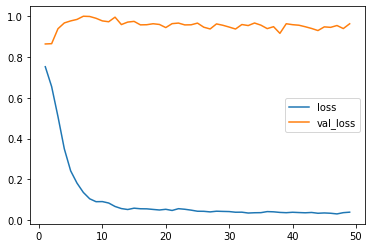

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
history_df.head()

,loss,val_loss,lr
0,0.976763,0.885032,0.001
1,0.751776,0.863152,0.001
2,0.654570,0.864562,0.001
3,0.507667,0.937705,0.001
4,0.349907,0.966075,0.001


In [15]:
# predict 
pred_test = model_KR.predict(final_test_vector)
pred_test_list = [i for i in pred_test]

In [16]:
# create submission file
submission = pd.DataFrame({'id' : test_data['id'], 'target' : pred_test_list})
submission.to_csv('submission.csv', index=False)
submission

,id,target
0,c0f722661,-1.420358
1,f0953f0a5,-1.254530
2,0df072751,-1.127209
3,04caf4e0c,-2.504905
4,0e63f8bea,-2.361248
5,12537fe78,-0.328222
6,965e592c0,0.109890
